# Capstone 3: Preprocessing and Training
<b>PROJECT GOAL</b><br>
The goal of this project is to understand and predict the valuation of publicly-traded companies as measured by market capitalization (the target or response variable).  Financial statement data will be used as predictor variables (features) to assess whether regression models of these fundamental variables can predict future market capitalization.<br>

<b>DATA</b><br>
All data are sourced from Alpha Vantage via their API (https://www.alphavantage.co/documentation/).

<i>response variable (target)</i><br>
market capitalization = [number of shares outstanding] x [share price]<br><br>
<i>predictor variables (features)</i><br>
The features are metrics from financial statements such as revenue, revenue growth year-over-year, etc.  A core set of metrics to be used as features was defined in the exploratory data analysis notebook.

Features are measured with respect to a quarterly fiscal reporting date, 'fisc_date_t', and with respect to dates relative to that date.  Financial statement metrics are measured on dates such as current quarter ('fisc_date_t'), next quarter ('fisc_date_tp1'), prior quarter ('fisc_date_tm1'), prior year ('fisc_date_tm4'), and prior quarter in the prior year ('fisc_date_tm5').  Stock prices are measured on measurement dates with respect to fiscal reporting dates, where the current measurement date ('meas_date_t') is the most recent trading date prior to the current fiscal reporting date ('fisc_date_t') and the next period measurement date ('meas_date_tp1') is similarly measured with respect to the next fiscal reporting date ('fisc_date_tp1') 

The target, market capitalization, 'mktcap_sec_tp1', is measured on date 'meas_date_tp1', the most recent trading date just prior to the next fiscal reporting date, 'fisc_date_tp1'.  The machine learning problem is to predict market capitalization ('mktcap_sec_tp1') just prior to the next fiscal reporting date ('fisc_date_tp1') using feature measurements from the current fiscal reporting date ('fisc_date_t').

The core features used in the analysis are:

clsadj_etf_t = adjusted close price of ETF ticker VTI on the most recent trading date prior to the current fiscal reporting date

rev = revenue for the fiscal quarter ending on the current fiscal reporting date<br> 
rev_yoy = year-over-year percent change in quarterly revenue for the current fiscal reporting date versus prior year<br>
rev_yoy_qdq = current quarter rev_yoy minus prior quarter rev_yoy

gp = gross profit for the fiscal quarter ending on the current fiscal reporting date<br> 
gp_mgn = gross profit margin, gross profit divided by revenue, for the fiscal quarter ending on the current fiscal reporting date<br>
gp_mgn_ydy = current quarter gross profit margin minus prior year gross profit margin

ni = net income for the fiscal quarter ending on the current fiscal reporting date <br>
ni_ydy = current quarter net income minus prior year net income<br>
ni_mgn = net income margin, net income divided by revenue, for the fiscal quarter ending on the current fiscal reporting date<br>
ni_mgn_ydy = current quarter net income margin minus prior year net income margin

sh_iss = total share issue amount in USD paid for the fiscal quarter ending on the current fiscal reporting date<br> 
sh_rprch = total share repurchase amount in USD paid for the fiscal quarter ending on the current fiscal reporting date<br> 
div = total dividend amount paid for the fiscal quarter ending on the current fiscal reporting date<br> 
div_ydy = current quarter total dividend amount paid minus prior year total dividend amount paid

cf_op = operating cash flow for the fiscal quarter ending on the current fiscal reporting date<br>
cf_op_ydy = current quarter operating cash flow minus prior year operating cash flow<br>
cf_op_mgn = operating cash flow margin, operating cash flow divided by revenue, for the fiscal quarter ending on the current fiscal reporting date<br>
cf_op_mgn_ydy = current quarter operating cash flow margin minus prior year operating cash flow margin

The data set has
* 2,122 distinct stock tickers
* 9,723 observations
* 1,692 (80%) stocks tickers with 5 observations 
* market cap in Sep 2021 ranging from \\$1.006 billion to \\$2.358 trillion 
* fiscal reporting dates ranging from 2020-01-31 to 2021-06-04

<b>PREPROCESSING AND TRAINING NOTEBOOK</b><br>
The purpose of this notebook is to:
<ol type="1">
  <li>using a training data set, fit three different kinds of machine learning models to the data to predict future market capitalization as a function of the financial metric features,</li>
  <li>evaluate the predictive accuracy of the models using a seperate test data set,</li>
  <li>quantify the relative importance of different features in explaining and predicting market capitalization.</li>
</ol> 

## 1 Import Python Modules, Load Data, Train-Test Split, Scale Data

Import Python modules, load target and feature data from exploratory data analysis notebook.

In [1]:
import pandas as pd
import numpy as np
import datetime as dttm
import itertools as itool

from sklearn.preprocessing import QuantileTransformer, RobustScaler  #StandardScaler, PowerTransformer
from sklearn.metrics import SCORERS, r2_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb

import matplotlib.pyplot as plt
import graphviz

import json

Save a copy of virtual environment to a text file.

In [2]:
#virtual environment
!pip freeze > env_spbdcp031.txt

In [3]:
#as of date
statusdate01 = dttm.date(2021,9,30)

In [4]:
#load target, feature data
data_elmt011 = 'yxdata_eda_'

#json
filnm011 = '../data/sec_' + data_elmt011 + statusdate01.strftime('%Y%m%d') + '.json'

with open(filnm011) as f011:
    sec_res_dict011 = json.load(f011)
        
df_sec_yxdata011 = pd.DataFrame.from_dict(sec_res_dict011)

lst_yxdata_dates011 = ['fisc_date_t', 'fisc_date_tp1', 'meas_date_t', 'meas_date_tp1', 
    'rpt_date_t', 'rpt_date_tp1', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5']

for lst_date_itm011 in lst_yxdata_dates011:
    df_sec_yxdata011.loc[:,lst_date_itm011] = pd.to_datetime(df_sec_yxdata011.loc[:,lst_date_itm011])
    
del f011, sec_res_dict011

<b>IN-SCOPE, CORE DATA</b>

Below are the data records and metrics defined as in-scope in the exploratory data analysis.  The modeling will be done on the target variable, market capitalization, 'mktcap_sec_tp1', with the additional 19 core metrics below as features (defined at top).

In [5]:
#define core metrics, data
lst_yx_coreattmet011 = ['ticker','mkt_cap_202109','fisc_seq','fisc_intvl','rpt_ccy','inscope_flg',
    'fisc_date_t', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5', 'meas_date_tp1',
    'mktcap_sec_tp1',
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']

#in scope, core attributes & metrics
is_yx_inscope011 = df_sec_yxdata011.loc[:,'inscope_flg'] == True
df_sec_yxdata_core011 = df_sec_yxdata011.loc[is_yx_inscope011,lst_yx_coreattmet011].copy()
df_sec_yxdata_core011.reset_index(drop=True,inplace=True)
df_sec_yxdata_core011.info()
df_sec_yxdata_core011.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9723 entries, 0 to 9722
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ticker          9723 non-null   object        
 1   mkt_cap_202109  9723 non-null   float64       
 2   fisc_seq        9723 non-null   float64       
 3   fisc_intvl      9723 non-null   float64       
 4   rpt_ccy         9723 non-null   object        
 5   inscope_flg     9723 non-null   bool          
 6   fisc_date_t     9723 non-null   datetime64[ns]
 7   fisc_date_tm1   9723 non-null   datetime64[ns]
 8   fisc_date_tm4   9723 non-null   datetime64[ns]
 9   fisc_date_tm5   9723 non-null   datetime64[ns]
 10  meas_date_tp1   9723 non-null   datetime64[ns]
 11  mktcap_sec_tp1  9723 non-null   float64       
 12  clsadj_etf_t    9723 non-null   float64       
 13  rev             9723 non-null   float64       
 14  rev_yoy         9723 non-null   float64       
 15  rev_

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,...,ni_mgn,ni_mgn_ydy,sh_iss,sh_rprch,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.265762,0.070318,561000000.0,1.854800e+10,3.447000e+09,72000000.0,2.398100e+10,1.067000e+10,0.269710,0.038440
1,AAPL,2.358033e+12,4.0,90.0,USD,True,2020-12-31,2020-09-30,2019-12-31,2019-09-30,...,0.259519,0.015259,0.0,2.477500e+10,3.613000e+09,74000000.0,3.876300e+10,8.247000e+09,0.349843,0.014628
2,AAPL,2.358033e+12,3.0,92.0,USD,True,2020-09-30,2020-06-30,2019-09-30,2019-06-30,...,0.195879,-0.017831,450000000.0,1.718700e+10,3.511000e+09,32000000.0,2.057600e+10,6.660000e+08,0.318031,0.007132
3,AAPL,2.358033e+12,2.0,92.0,USD,True,2020-06-30,2020-03-31,2019-06-30,2019-03-31,...,0.190768,0.001054,0.0,1.589100e+10,3.656000e+09,27000000.0,1.627100e+10,4.635000e+09,0.275836,0.056052
4,AAPL,2.358033e+12,1.0,91.0,USD,True,2020-03-31,2019-12-31,2019-03-31,2018-12-31,...,0.195444,-0.007362,428000000.0,1.857400e+10,3.375000e+09,-68000000.0,1.331100e+10,2.156000e+09,0.231270,0.035586


In [6]:
#summary statistics
#count of distinct stock tickers
ntick011 = len(df_sec_yxdata_core011.loc[:,'ticker'].unique())
#count of records
nrcd011 = df_sec_yxdata_core011.loc[:,'ticker'].count()
#count of stock tickers with 5 records
ntick5rcd011 = int((df_sec_yxdata_core011.loc[:,['ticker','fisc_seq']].groupby('ticker').count() >= 5).sum())
#percent of stock tickers with 5 records
pcttick5rcd011 = ntick5rcd011/ntick011
#minimum market cap
mc_min011 = df_sec_yxdata_core011.loc[:,'mkt_cap_202109'].min()
#maximum market cap
mc_max011 = df_sec_yxdata_core011.loc[:,'mkt_cap_202109'].max()
#minimum fiscal date
fdt_min011 = df_sec_yxdata_core011.loc[:,'fisc_date_t'].min()
#maximum fiscal date
fdt_max011 = df_sec_yxdata_core011.loc[:,'fisc_date_t'].max()

print(ntick011,nrcd011,ntick5rcd011,pcttick5rcd011,mc_min011,mc_max011,fdt_min011,fdt_max011)

2122 9723 1692 0.7973609802073516 1005768000.0 2358032990000.0 2020-01-31 00:00:00 2021-06-04 00:00:00


<b>TRAIN-TEST SPLIT</b>

For each stock ticker, data are captured for the last 5 prior fiscal period reporting dates.  The sequence of these records are identified with column 'fisc_seq'.  The lastest reporting period, identified with 'fisc_seq' == 5.0, will serve as the test data and the prior four periods, identified with 'fisc_seq' <= 4.0, will serve as the training data. Hence, the latest 20% of the data is used for testing and the prior 80% of the data is used for training.

In [7]:
#core attributes, target & features, features
lst_yx_coreatt011 = ['ticker','mkt_cap_202109','fisc_seq','fisc_intvl','rpt_ccy','inscope_flg',
    'fisc_date_t', 'fisc_date_tm1', 'fisc_date_tm4', 'fisc_date_tm5', 'meas_date_tp1' ]
lst_yx_coretrgtfeat011 = [
    'mktcap_sec_tp1',
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']
lst_yx_corefeat011 = [
    'clsadj_etf_t',
    'rev', 'rev_yoy', 'rev_yoy_qdq', 
    'gp', 'gp_mgn', 'gp_mgn_ydy', 
    'ni', 'ni_ydy', 'ni_mgn', 'ni_mgn_ydy', 
    'sh_iss', 'sh_rprch', 'div', 'div_ydy',
    'cf_op', 'cf_op_ydy', 'cf_op_mgn', 'cf_op_mgn_ydy']

#train
is_train_core_seq011 = df_sec_yxdata_core011.loc[:,'fisc_seq'] <= 4.0
df_yx_train_core011 = df_sec_yxdata_core011.loc[is_train_core_seq011,lst_yx_coretrgtfeat011]
#test
df_yx_test_core011 = df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coretrgtfeat011]

In [8]:
df_yx_train_core011.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7748 entries, 1 to 9722
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mktcap_sec_tp1  7748 non-null   float64
 1   clsadj_etf_t    7748 non-null   float64
 2   rev             7748 non-null   float64
 3   rev_yoy         7748 non-null   float64
 4   rev_yoy_qdq     7748 non-null   float64
 5   gp              7748 non-null   float64
 6   gp_mgn          7748 non-null   float64
 7   gp_mgn_ydy      7748 non-null   float64
 8   ni              7748 non-null   float64
 9   ni_ydy          7748 non-null   float64
 10  ni_mgn          7748 non-null   float64
 11  ni_mgn_ydy      7748 non-null   float64
 12  sh_iss          7748 non-null   float64
 13  sh_rprch        7748 non-null   float64
 14  div             7748 non-null   float64
 15  div_ydy         7748 non-null   float64
 16  cf_op           7748 non-null   float64
 17  cf_op_ydy       7748 non-null   f

In [9]:
df_yx_test_core011.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 9718
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mktcap_sec_tp1  1975 non-null   float64
 1   clsadj_etf_t    1975 non-null   float64
 2   rev             1975 non-null   float64
 3   rev_yoy         1975 non-null   float64
 4   rev_yoy_qdq     1975 non-null   float64
 5   gp              1975 non-null   float64
 6   gp_mgn          1975 non-null   float64
 7   gp_mgn_ydy      1975 non-null   float64
 8   ni              1975 non-null   float64
 9   ni_ydy          1975 non-null   float64
 10  ni_mgn          1975 non-null   float64
 11  ni_mgn_ydy      1975 non-null   float64
 12  sh_iss          1975 non-null   float64
 13  sh_rprch        1975 non-null   float64
 14  div             1975 non-null   float64
 15  div_ydy         1975 non-null   float64
 16  cf_op           1975 non-null   float64
 17  cf_op_ydy       1975 non-null   f

<b>SCALING THE DATA</b>

In general, model fitting methods and their subsequent interpretation are sensitive to the scales and distributions of the target and feature variables.  With regard to distributions, models may also be sensitive to extreme values in the data.  Accordingly, because the variables in this data set have long-tailed distributions, I transformed the data using the RobustScaler method which centers and scales the data using quantiles.  Here, data are centered with the median scaled with the quantile range 10% to 90%.

In [10]:
#scalers for {y,x}, y, x on training data
scaler_yx_011 = RobustScaler(with_centering=True,with_scaling=True,quantile_range=(0.10,0.90))
scaler_y_011 = RobustScaler(with_centering=True,with_scaling=True,quantile_range=(0.10,0.90))
scaler_x_011 = RobustScaler(with_centering=True,with_scaling=True,quantile_range=(0.10,0.90))
sclprm_yx_train_011 = scaler_yx_011.fit(df_yx_train_core011)
sclprm_y_train_011 = scaler_y_011.fit(df_yx_train_core011.loc[:,['mktcap_sec_tp1']])
sclprm_x_train_011 = scaler_x_011.fit(df_yx_train_core011.loc[:,lst_yx_corefeat011])

#scale {y,x} data by training scale
yxscaled_train_011 = sclprm_yx_train_011.transform(df_yx_train_core011)
yxscaled_test_011 = sclprm_yx_train_011.transform(df_yx_test_core011)

#dataframe
df_yx_train_scld011 = pd.DataFrame(yxscaled_train_011, index=df_yx_train_core011.index, columns=lst_yx_coretrgtfeat011)
df_yx_test_scld011 = pd.DataFrame(yxscaled_test_011, index=df_yx_test_core011.index, columns=lst_yx_coretrgtfeat011)

#combine attribute, target, feature data with target and features scaled
df_yx_train_reg011 = pd.concat( [df_sec_yxdata_core011.loc[is_train_core_seq011,lst_yx_coreatt011], df_yx_train_scld011 ], axis=1 )
df_yx_test_reg011 = pd.concat( [df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011], df_yx_test_scld011 ], axis=1 )

In [11]:
#train, test data
df_x_train011 = df_yx_train_reg011.loc[:,lst_yx_corefeat011]
df_y_train011 = df_yx_train_reg011.loc[:,['mktcap_sec_tp1']]
df_x_test011 = df_yx_test_reg011.loc[:,lst_yx_corefeat011]
df_y_test011 = df_yx_test_reg011.loc[:,['mktcap_sec_tp1']]

Below are histograms of the target and features variables after scaling with RobustScaler.  Further below are some tabluar summaries of the scaled data.

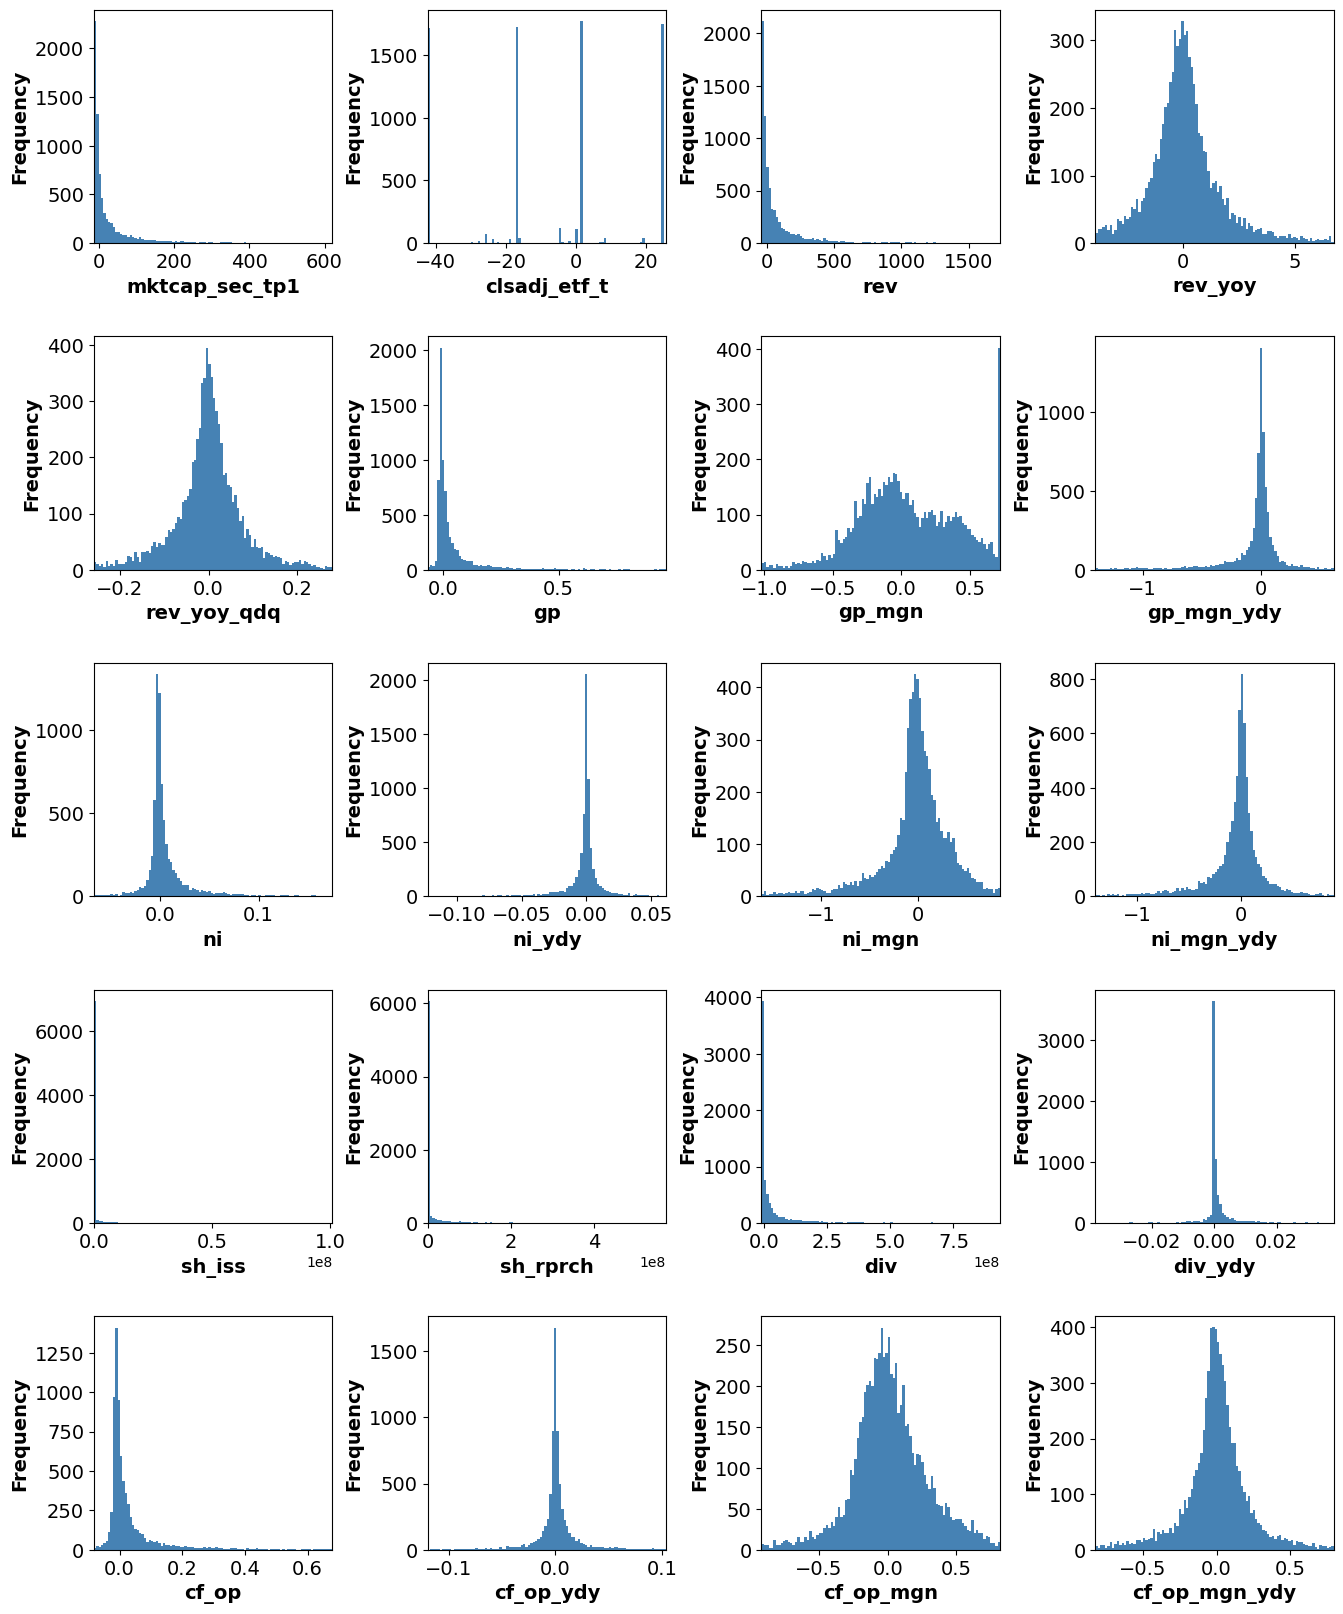

In [12]:
#plot histograms of training data
fig011, axes011 = plt.subplots(nrows=5,ncols=4,figsize=(16,20))
fig011.subplots_adjust(wspace=0.4,hspace=0.4)
axes_flt011 = axes011.flatten()

n_coremet011 = len(lst_yx_coretrgtfeat011)

for idx011 in range(0,n_coremet011):
    colplt011 = lst_yx_coretrgtfeat011[idx011]
    
    #bins
    lwbd011 = df_yx_train_reg011.loc[:,colplt011].quantile(0.02)
    upbd011 = df_yx_train_reg011.loc[:,colplt011].quantile(0.98)
    bwdth011 = (upbd011 - lwbd011)/100
    bin_p011 = np.arange(lwbd011, upbd011 + bwdth011, bwdth011)
    axes_flt011[idx011].set_xlim(lwbd011,upbd011)
    
    df_yx_train_reg011.loc[:,colplt011].plot(ax=axes_flt011[idx011],kind='hist',bins=bin_p011,color='steelblue')
    axes_flt011[idx011].set_xlabel(colplt011, fontsize=14.0, fontweight='bold')
    axes_flt011[idx011].tick_params(axis='x', labelsize=14)
    axes_flt011[idx011].set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
    axes_flt011[idx011].tick_params(axis='y', labelsize=14) 

plt.show()

In [13]:
df_yx_train_reg011.head(12)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,...,ni_mgn,ni_mgn_ydy,sh_iss,sh_rprch,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy
1,AAPL,2.358033e+12,4.0,90.0,USD,True,2020-12-31,2020-09-30,2019-12-31,2019-09-30,...,0.336470,0.032702,0.0,2.477500e+10,3.604452e+09,0.028687,7.876179,0.888071,0.208939,0.002705
2,AAPL,2.358033e+12,3.0,92.0,USD,True,2020-09-30,2020-06-30,2019-09-30,2019-06-30,...,0.226268,-0.022072,450000000.0,1.718700e+10,3.502452e+09,0.012405,4.173401,0.071238,0.170193,-0.007262
3,AAPL,2.358033e+12,2.0,92.0,USD,True,2020-06-30,2020-03-31,2019-06-30,2019-03-31,...,0.217417,0.009189,0.0,1.589100e+10,3.647452e+09,0.010467,3.296925,0.498887,0.118800,0.057784
4,AAPL,2.358033e+12,1.0,91.0,USD,True,2020-03-31,2019-12-31,2019-03-31,2018-12-31,...,0.225515,-0.004743,428000000.0,1.857400e+10,3.366452e+09,-0.026361,2.694284,0.231781,0.064521,0.030571
6,MSFT,2.172555e+12,4.0,90.0,USD,True,2020-12-31,2020-09-30,2019-12-31,2019-09-30,...,0.516248,0.078001,302000000.0,6.535000e+09,4.221452e+09,0.133357,2.532427,0.197302,0.141036,-0.016670
7,MSFT,2.172555e+12,3.0,92.0,USD,True,2020-09-30,2020-06-30,2019-09-30,2019-06-30,...,0.542169,0.088596,545000000.0,6.743000e+09,3.847452e+09,0.134133,3.920739,0.593920,0.424094,0.116726
8,MSFT,2.172555e+12,2.0,92.0,USD,True,2020-06-30,2020-03-31,2019-06-30,2019-03-31,...,0.397102,-0.152418,340000000.0,5.791000e+09,3.856452e+09,0.133357,3.785960,0.275850,0.380824,0.000843
9,MSFT,2.172555e+12,1.0,91.0,USD,True,2020-03-31,2019-12-31,2019-03-31,2018-12-31,...,0.429654,0.039938,342000000.0,7.059000e+09,3.867452e+09,0.135683,3.547957,0.428743,0.404123,0.062137
11,GOOGL,1.820299e+12,4.0,90.0,USD,True,2020-12-31,2020-09-30,2019-12-31,2019-09-30,...,0.356937,0.068966,0.0,7.904000e+09,-8.547500e+06,0.000000,4.601153,0.888394,0.275015,0.099595
12,GOOGL,1.820299e+12,3.0,92.0,USD,True,2020-09-30,2020-06-30,2019-09-30,2019-06-30,...,0.309268,0.122166,0.0,7.897000e+09,-8.547500e+06,0.000000,3.445956,0.165086,0.231770,-0.034375


In [14]:
df_yx_test_reg011.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,...,ni_mgn,ni_mgn_ydy,sh_iss,sh_rprch,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.347280,0.123842,561000000.0,1.854800e+10,3.438452e+09,0.027912,4.866641,1.149143,0.111339,0.034366
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.538965,0.111937,396000000.0,6.930000e+09,4.212452e+09,0.133745,4.499763,0.503197,0.440754,0.023246
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.448385,0.269086,0.0,1.139500e+10,-8.547500e+06,0.000000,3.911374,0.844002,0.207568,0.077000
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.448385,0.269086,0.0,1.139500e+10,-8.547500e+06,0.000000,3.911374,0.844002,0.207568,0.077000
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.016956,0.075686,0.0,0.000000e+00,-8.547500e+06,0.000000,0.841979,0.123280,-0.169685,-0.019203
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.515553,0.150661,0.0,3.939000e+09,-8.547500e+06,0.000000,2.476642,0.133192,0.352656,-0.219503
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,-0.039918,0.072806,0.0,0.000000e+00,-8.547500e+06,0.000000,0.318333,0.223700,-0.024774,0.291028
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.201001,1.651615,0.0,6.580000e+09,-8.547500e+06,0.000000,1.878887,0.269708,-0.041701,0.027262
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,...,0.471936,0.073693,0.0,0.000000e+00,9.045250e+07,0.000388,0.365771,0.103454,0.186033,0.030998
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,...,0.821444,0.010793,0.0,1.713000e+09,6.924525e+08,0.012793,0.662001,0.200104,0.505845,0.432547


In [15]:
df_x_train011.info()
df_y_train011.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7748 entries, 1 to 9722
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clsadj_etf_t   7748 non-null   float64
 1   rev            7748 non-null   float64
 2   rev_yoy        7748 non-null   float64
 3   rev_yoy_qdq    7748 non-null   float64
 4   gp             7748 non-null   float64
 5   gp_mgn         7748 non-null   float64
 6   gp_mgn_ydy     7748 non-null   float64
 7   ni             7748 non-null   float64
 8   ni_ydy         7748 non-null   float64
 9   ni_mgn         7748 non-null   float64
 10  ni_mgn_ydy     7748 non-null   float64
 11  sh_iss         7748 non-null   float64
 12  sh_rprch       7748 non-null   float64
 13  div            7748 non-null   float64
 14  div_ydy        7748 non-null   float64
 15  cf_op          7748 non-null   float64
 16  cf_op_ydy      7748 non-null   float64
 17  cf_op_mgn      7748 non-null   float64
 18  cf_op_mg

In [16]:
df_x_test011.info()
df_y_test011.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 9718
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   clsadj_etf_t   1975 non-null   float64
 1   rev            1975 non-null   float64
 2   rev_yoy        1975 non-null   float64
 3   rev_yoy_qdq    1975 non-null   float64
 4   gp             1975 non-null   float64
 5   gp_mgn         1975 non-null   float64
 6   gp_mgn_ydy     1975 non-null   float64
 7   ni             1975 non-null   float64
 8   ni_ydy         1975 non-null   float64
 9   ni_mgn         1975 non-null   float64
 10  ni_mgn_ydy     1975 non-null   float64
 11  sh_iss         1975 non-null   float64
 12  sh_rprch       1975 non-null   float64
 13  div            1975 non-null   float64
 14  div_ydy        1975 non-null   float64
 15  cf_op          1975 non-null   float64
 16  cf_op_ydy      1975 non-null   float64
 17  cf_op_mgn      1975 non-null   float64
 18  cf_op_mg

In [17]:
df_x_train011.describe()

,clsadj_etf_t,rev,rev_yoy,rev_yoy_qdq,gp,gp_mgn,gp_mgn_ydy,ni,ni_ydy,ni_mgn,ni_mgn_ydy,sh_iss,sh_rprch,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy
count,7748.000000,7748.000000,7.748000e+03,7748.000000,7748.000000,7748.000000,7748.000000,7748.000000,7748.000000,7.748000e+03,7.748000e+03,7.748000e+03,7.748000e+03,7.748000e+03,7748.000000,7748.000000,7748.000000,7.748000e+03,7748.000000
mean,-7.256902,157.690343,2.763361e-01,0.000794,0.082047,0.022622,-0.072921,0.010500,-0.006479,-4.028434e-02,-5.135216e-02,1.370647e+07,7.350407e+07,8.996874e+07,-0.001866,0.056748,-0.001796,1.105819e-02,-0.002182
std,24.216357,638.454907,3.624645e+00,0.220606,0.447383,0.420412,0.399048,0.135005,0.109909,5.300265e-01,4.613198e-01,2.319415e+08,6.468836e+08,3.907750e+08,0.082738,0.321125,0.112780,3.790391e-01,0.349654
min,-54.358022,-45.525986,-5.929247e+00,-7.958971,-5.336294,-2.752527,-2.945419,-5.136317,-6.540212,-3.565388e+00,-3.261130e+00,0.000000e+00,0.000000e+00,-8.547500e+06,-2.457031,-6.660692,-3.323559,-2.639741e+00,-2.614375
25%,-17.137747,-29.235244,-7.759081e-01,-0.036124,-0.013660,-0.222879,-0.067992,-0.003389,-0.003464,-1.337240e-01,-1.133201e-01,0.000000e+00,0.000000e+00,-8.547500e+06,0.000000,-0.012304,-0.003512,-1.451938e-01,-0.093066
50%,0.000000,0.000000,5.637851e-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.201432e-17,-7.178604e-19,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,1.690000e-17,0.000000
75%,19.139159,96.686007,8.038625e-01,0.037856,0.042605,0.321365,0.035580,0.009284,0.002225,1.670434e-01,7.028329e-02,0.000000e+00,1.531500e+06,3.745250e+07,0.001049,0.035946,0.004864,1.757046e-01,0.101854
max,50.839793,13895.846072,2.218831e+02,10.118740,15.168419,1.572258,2.400425,3.694874,1.246969,3.148672e+00,3.263992e+00,1.729000e+10,2.477500e+10,8.287452e+09,3.216082,7.876179,1.808341,2.217137e+00,2.603182


In [18]:
df_y_train011.describe()

,mktcap_sec_tp1
count,7748.000000
mean,61.218452
std,321.518332
min,-15.219033
25%,-8.683268
50%,0.000000
75%,33.734802
max,8680.414696


In [19]:
df_x_test011.describe()

,clsadj_etf_t,rev,rev_yoy,rev_yoy_qdq,gp,gp_mgn,gp_mgn_ydy,ni,ni_ydy,ni_mgn,ni_mgn_ydy,sh_iss,sh_rprch,div,div_ydy,cf_op,cf_op_ydy,cf_op_mgn,cf_op_mgn_ydy
count,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000,1.975000e+03,1.975000e+03,1.975000e+03,1975.000000,1975.000000,1975.000000,1975.000000,1975.000000
mean,38.575191,175.042579,1.520833,0.037072,0.094154,0.035005,0.085062,0.024180,0.017699,0.014329,0.125166,1.648961e+07,9.337861e+07,8.377372e+07,-0.001346,0.051834,0.004446,-0.020787,0.037326
std,3.726804,678.551626,9.524252,0.299554,0.464149,0.376874,0.424079,0.116560,0.146280,0.473845,0.481633,1.273572e+08,6.687246e+08,3.573365e+08,0.046319,0.298410,0.113874,0.387050,0.376388
min,-17.137747,-45.106458,-5.889404,-8.542934,-2.600429,-2.057713,-2.948754,-0.213796,-0.507482,-3.338520,-3.138896,0.000000e+00,0.000000e+00,-8.547500e+06,-0.694311,-0.722239,-2.235526,-2.431334,-2.563047
25%,37.721246,-28.143361,-0.008167,-0.004801,-0.012361,-0.204341,-0.019266,-0.002373,0.000009,-0.081580,-0.004690,0.000000e+00,0.000000e+00,-8.547500e+06,0.000000,-0.013471,-0.002342,-0.178476,-0.077757
50%,37.721246,4.455083,0.719444,0.026636,0.003136,0.031018,0.019849,0.001758,0.002097,0.030505,0.059474,0.000000e+00,0.000000e+00,-1.034500e+06,0.000000,-0.002648,0.000920,-0.045344,0.014429
75%,37.721246,111.437900,1.812646,0.069339,0.048962,0.298919,0.104548,0.013176,0.009460,0.193433,0.204190,0.000000e+00,8.624500e+06,3.587550e+07,0.000780,0.026185,0.008028,0.144660,0.131435
max,50.839793,12633.560353,294.561511,4.467224,7.752696,0.841234,2.787008,2.435428,5.629112,3.329158,3.238248,3.587825e+09,1.854800e+10,7.359452e+09,0.920929,5.456658,1.149143,2.185461,2.634085


In [20]:
df_y_test011.describe()

,mktcap_sec_tp1
count,1975.000000
mean,80.478341
std,413.459580
min,-15.208135
25%,-5.914185
50%,5.054123
75%,47.927298
max,8553.191876


## 2 Linear Regression Model

<b>2.1 LINEAR REGRESSION: MODEL SELECTION BY CROSS VALIDATION</b>

Here, I fit a set of linear regression models using the features as 1st-order predictor variables.  I evaluate all combinations of the features to identify the best subset of features to include in the linear regression model.  F-statistics combined with a Lasso regression model are used to select the best subset of features (via the procedure SelectKBest).  The Lasso regularization parameter and subsets of features (k best features) are evaluated using a grid search and cross validation with mean absolute error (MAE) as the scoring metric.

In [21]:
#gridsearch cross validation: best k linear lasso regressors
nfeat021 = len(df_x_train011.columns)

#seed
np.random.seed(dttm.datetime.now().microsecond)

#grid search, cross validation
lr_pipe021 = Pipeline( [ ('selector',SelectKBest(f_regression)), ('model',Lasso()) ] )
lr_gscv021 = GridSearchCV( estimator = lr_pipe021, param_grid = {'selector__k':list(range(1,(nfeat021+1))), 
    'model__alpha':[0.05,0.1,0.5,1,2]},
    scoring='neg_mean_absolute_error', cv=4, verbose=False, n_jobs=4 )
lr_gscv021.fit(df_x_train011,df_y_train011.values.ravel())

df_lr_gscv_res021 = pd.DataFrame(lr_gscv021.cv_results_)

Below are the results of the model selection for the top 10 models sorted by MAE (mean_test_score).  Models with about 7 to 11 parameters fit similarly well.

In [22]:
df_lr_gscv_res021.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
6,0.078754,0.012822,0.016719,0.000207,0.05,7,"{'model__alpha': 0.05, 'selector__k': 7}",-206.960419,-27.119180,-15.798718,-14.942185,-66.205126,81.407092,1
9,0.093444,0.016506,0.017057,0.000624,0.05,10,"{'model__alpha': 0.05, 'selector__k': 10}",-207.126838,-27.012772,-15.798935,-15.460144,-66.349672,81.410569,2
8,0.089326,0.015305,0.017264,0.000180,0.05,9,"{'model__alpha': 0.05, 'selector__k': 9}",-207.126838,-27.100117,-15.817971,-15.537685,-66.395653,81.384950,3
10,0.100594,0.019729,0.016827,0.000453,0.05,11,"{'model__alpha': 0.05, 'selector__k': 11}",-207.188494,-27.104528,-15.863465,-15.472201,-66.407172,81.414243,4
7,0.085498,0.014605,0.017464,0.000545,0.05,8,"{'model__alpha': 0.05, 'selector__k': 8}",-207.646511,-27.218253,-16.003327,-15.248136,-66.529057,81.611974,5
25,0.077037,0.013575,0.016716,0.000200,0.1,7,"{'model__alpha': 0.1, 'selector__k': 7}",-209.804971,-27.089906,-15.814455,-14.991870,-66.925300,82.629986,6
28,0.088481,0.019445,0.016974,0.000550,0.1,10,"{'model__alpha': 0.1, 'selector__k': 10}",-209.397853,-27.023844,-15.835418,-15.512990,-66.942526,82.377113,7
27,0.084584,0.018119,0.017252,0.000322,0.1,9,"{'model__alpha': 0.1, 'selector__k': 9}",-209.397853,-27.100169,-15.853359,-15.572693,-66.981018,82.355769,8
29,0.096542,0.024749,0.017576,0.000709,0.1,11,"{'model__alpha': 0.1, 'selector__k': 11}",-209.435877,-27.099706,-15.888655,-15.523106,-66.986836,82.374529,9
26,0.082751,0.016667,0.017227,0.000817,0.1,8,"{'model__alpha': 0.1, 'selector__k': 8}",-209.767529,-27.193674,-16.026132,-15.307223,-67.073640,82.519040,10


<b>2.2 LINEAR REGRESSION: TESTING</b>

Selecting a linear regression model with k = 7 features as predictor variables as the best model, I fit this model to the training data, generate predictions for the target variable using the test data, and evaluate the accuracy of the predictions.  Accuracy is assessed on the original, untransformed test data. I also measure the relative importance of the features in the model.

In [23]:
#linear regression model: fit model with k best regressors
kbest021 = 7

#select k best regressors
lr_sel_kbest021 = SelectKBest(f_regression,k=kbest021).fit(df_x_train011,df_y_train011.values.ravel())
lr_feat_kbest021 = list(lr_sel_kbest021.get_feature_names_out())

x_kbest021 = lr_sel_kbest021.transform(df_x_train011)
df_x_kbest_train021 = df_x_train011.loc[:,lr_feat_kbest021]

#fit linear regression
lr_model_kbest021 = LinearRegression()
lr_model_kbest021.fit(df_x_kbest_train021,df_y_train011.values.ravel())

LinearRegression()

Predictions for the target variable and associated accuracy metrics are calculated on the original, untransformed data.

In [24]:
#predictions

#kbest for test set
df_x_kbest_test021 = df_x_test011.loc[:,lr_feat_kbest021]

#scaled
df_lr_model_pred021 = pd.concat([df_y_test011,pd.Series(lr_model_kbest021.predict(df_x_kbest_test021),index=df_x_kbest_test021.index)],axis=1)
df_lr_model_pred021.columns = ['y_obs','y_pred']

#unscaled, back-transform
df_lr_model_pred021 = pd.concat([df_lr_model_pred021,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_lr_model_pred021.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)
df_lr_model_pred_temp021 = df_lr_model_pred021.loc[:,['y_pred']].copy()
df_lr_model_pred_temp021.rename(columns={'y_pred':'mktcap_sec_tp1'},inplace=True)
ary_lr_y_pred_temp021 = sclprm_y_train_011.inverse_transform(df_lr_model_pred_temp021.loc[:,['mktcap_sec_tp1']])
df_lr_model_pred021 = pd.concat([df_lr_model_pred021,pd.DataFrame(ary_lr_y_pred_temp021,index=df_x_test011.index,columns=['mc_pred'])],axis=1)

#fit metrics
df_lr_model_pred021.loc[:,'mc_resid'] = df_lr_model_pred021.loc[:,'mc_obs'] - df_lr_model_pred021.loc[:,'mc_pred']
df_lr_model_pred021.loc[:,'mc_ae'] = df_lr_model_pred021.loc[:,'mc_resid'].abs()
df_lr_model_pred021.loc[:,'mc_ape'] = df_lr_model_pred021.loc[:,'mc_ae']/df_lr_model_pred021.loc[:,'mc_obs'].abs()
df_lr_model_pred021 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_lr_model_pred021],axis=1)

df_lr_model_pred021.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8553.191876,5578.300956,2.245600e+12,1.465944e+12,7.796556e+11,7.796556e+11,0.347193
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7694.841722,3620.104913,2.020644e+12,9.527426e+11,1.067902e+12,1.067902e+12,0.528496
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6260.231303,4052.597068,1.644663e+12,1.066090e+12,5.785739e+11,5.785739e+11,0.351789
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6479.602887,4052.597068,1.702156e+12,1.066090e+12,6.360666e+11,6.360666e+11,0.373683
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6607.672995,1788.718825,1.735721e+12,4.727752e+11,1.262945e+12,1.262945e+12,0.727620
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,3848.145274,2273.990611,1.012507e+12,5.999546e+11,4.125524e+11,4.125524e+11,0.407456
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,2515.455134,138.587785,6.632374e+11,4.031102e+10,6.229263e+11,6.229263e+11,0.939221
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,3819.136808,3151.312709,1.004905e+12,8.298821e+11,1.750225e+11,1.750225e+11,0.174168
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,446.724742,261.438786,1.210672e+11,7.250765e+10,4.855951e+10,4.855951e+10,0.401096
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,1724.123481,566.528538,4.558462e+11,1.524652e+11,3.033810e+11,3.033810e+11,0.665534


For the model predictions of the target variable I calculate r-squared and aboslute prediction error (APE) - both mean and median.  

The r-squared value is fairly high, about 70%, but the absolute prediction errors are very high.  The mean APE is much greater than 1 whereas the median APE is about 60%.  These results may be driven in part by the extreme values in the data (long-tailed distributions). 

In [25]:
#r-squared, mean-ape, median-ape
lr_r2 = r2_score(df_lr_model_pred021.loc[:,'mc_obs'], df_lr_model_pred021.loc[:,'mc_pred'])
lr_meanape = df_lr_model_pred021.loc[:,'mc_ape'].mean()
lr_medape = df_lr_model_pred021.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = pd.DataFrame([['LR',lr_r2,lr_meanape,lr_medape]],
        columns=['model','r-squared','mean-ape','median-ape'],index=[0])
df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.700325,2.347315,0.597431


Observed market capitalization is plotted against its prediction on the test data.  Values have been transformed back to their original scale.

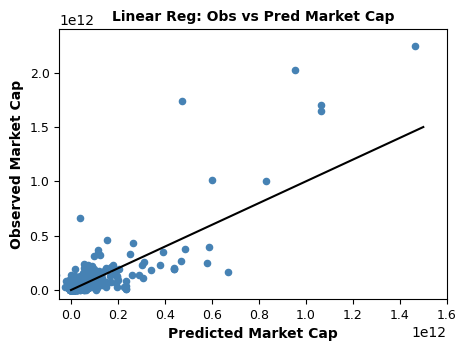

In [26]:
#obs vs pred scatterplot
axes021 = df_lr_model_pred021.plot(x='mc_pred',y='mc_obs',kind='scatter',color='steelblue',figsize=(5,3.5))

axes021.set_title('Linear Reg: Obs vs Pred Market Cap', fontsize = 10.0, fontweight='bold')
axes021.set_xlabel('Predicted Market Cap', fontsize = 10.0, fontweight='bold')
axes021.tick_params(axis='x', labelsize=9)
axes021.set_ylabel('Observed Market Cap', fontsize = 10.0, fontweight='bold') 
axes021.tick_params(axis='y', labelsize=9)
axes021.set_xlim(-0.5*10**11,1.6*10**12)     #set_xlim(-0.1*10**11,0.1*10**12)
axes021.set_ylim(-0.8*10**11,2.4*10**12)     #set_ylim(-0.1*10**11,0.4*10**12)

#y=x line
plt.plot([0,1.5*10**12],[0,1.5*10**12],'-',color='k')

plt.show()

Feature importance is calculated using the linear regression coefficients from the fit on the training data.  Coefficients are mulitplied by 1 standard deviation of the feature value to model the effect of a 1-standard deviation change in the feature and its impact on the target variable.  Relative importance values are calculated by dividing each importance value by the sum of the absolute values of the importance values.  Relative importance values are then sorting by descending magnitude.

In [27]:
#feature importance
lr_featimp_std021 = lr_model_kbest021.coef_*np.array(df_x_kbest_train021.std())
lr_featimp021 = lr_featimp_std021/np.sum(np.abs(lr_featimp_std021))

df_lr_model_featimp021 = pd.concat([pd.Series(df_x_kbest_train021.columns),pd.Series(lr_featimp021).abs(),
    pd.Series(lr_featimp021)], axis=1)
df_lr_model_featimp021.columns = ['feature','importance_abs','importance']
df_lr_model_featimp021.sort_values(by='importance_abs',ascending=False,inplace=True)
df_lr_model_featimp021.reset_index(inplace=True)
df_lr_model_featimp021.columns = ['idx_feat','feat_label','importance_abs','importance']
df_lr_model_featimp021

,idx_feat,feat_label,importance_abs,importance
0,5,cf_op,0.325086,0.325086
1,3,sh_rprch,0.175523,0.175523
2,6,cf_op_ydy,0.133543,-0.133543
3,2,ni,0.120050,0.120050
4,1,gp,0.111554,0.111554
5,0,rev,0.108771,0.108771
6,4,div,0.025472,-0.025472


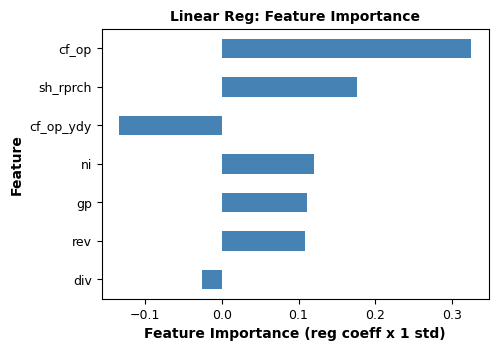

In [28]:
#feature importance plot
axes022 = df_lr_model_featimp021.sort_values(by='importance_abs').plot.barh(x='feat_label',y='importance',rot=0,color='steelblue',figsize=(5,3.5))

axes022.set_title('Linear Reg: Feature Importance', fontsize = 10, fontweight='bold')
axes022.set_xlabel('Feature Importance (reg coeff x 1 std)', fontsize = 10, fontweight='bold')
axes022.tick_params(axis='x', labelsize=9)
axes022.set_ylabel('Feature', fontsize = 10, fontweight='bold') 
axes022.tick_params(axis='y', labelsize=9)
axes022.get_legend().remove()

plt.show()

<b>2.3 LINEAR REGRESSION: CONCLUSIONS</b>

This analysis suggests the following conclusions for the linear regression model:

* Cross validation indicates that a model with about 7 features provides the best fit without including excessive parameters.
* The peformance of the model on the test data varies based on the metric.  By the r-squared metric, the fit is quite good, but the absolute prediction error metrics are high.  These results may be driven in part by the large range in  values in the data.  The r-squared value suggests the model is explaining about 70% of the variation in the target, but the range of variation in the target is large. It seems the model is capturing the large trends in the data, but not predicting very accurately the specific market capitalization of many individual companies.
* The most important features in this linear model are operating cash flow, share repurchase amount, year-over-year change in operating cash flow, net income, gross profit, revenue, and dividend amount.  All effects are in the positive direction as expected and consistent with the exploratory data analysis except for the effects of year-over-year change in operating cash flow and dividend amount, which are negative.  These negative effects may indicate more complex effects that the linear model is unable to capture.

## 3 XGBoost Decision Tree Model

<b>3.1 XGBOOST DECISION TREE: MODEL SELECTION BY CROSS VALIDATION</b>

In this section, I fit a boosted decision tree using the Python package xgboost.  I evaluate a set of models by cross validation with a grid search of several hyperparameters using mean absolute error (MAE) as the scoring metric.

In [29]:
#gridsearch cross validations: hyperparameters
#train data matrix
xgb_DM_train031 = xgb.DMatrix(df_x_train011,label=df_y_train011)
#parameter grid
xgb_gscv_grid031 = {'booster':['gbtree'],'max_depth':[2,4,6,8],'learning_rate':[0.1],
    'colsample_bynode':[0.6,0.8,1.0],'reg_alpha':[0.5,1]}
#permuations of parameter grid
keys031, values031 = zip(*xgb_gscv_grid031.items())
lst_xgb_gscv_grid031 = [dict(zip(keys031, v031)) for v031 in itool.product(*values031)]

In [30]:
lst_xgb_gscv_grid031[0:19]

[{'booster': 'gbtree',
  'max_depth': 2,
  'learning_rate': 0.1,
  'colsample_bynode': 0.6,
  'reg_alpha': 0.5},
 {'booster': 'gbtree',
  'max_depth': 2,
  'learning_rate': 0.1,
  'colsample_bynode': 0.6,
  'reg_alpha': 1},
 {'booster': 'gbtree',
  'max_depth': 2,
  'learning_rate': 0.1,
  'colsample_bynode': 0.8,
  'reg_alpha': 0.5},
 {'booster': 'gbtree',
  'max_depth': 2,
  'learning_rate': 0.1,
  'colsample_bynode': 0.8,
  'reg_alpha': 1},
 {'booster': 'gbtree',
  'max_depth': 2,
  'learning_rate': 0.1,
  'colsample_bynode': 1.0,
  'reg_alpha': 0.5},
 {'booster': 'gbtree',
  'max_depth': 2,
  'learning_rate': 0.1,
  'colsample_bynode': 1.0,
  'reg_alpha': 1},
 {'booster': 'gbtree',
  'max_depth': 4,
  'learning_rate': 0.1,
  'colsample_bynode': 0.6,
  'reg_alpha': 0.5},
 {'booster': 'gbtree',
  'max_depth': 4,
  'learning_rate': 0.1,
  'colsample_bynode': 0.6,
  'reg_alpha': 1},
 {'booster': 'gbtree',
  'max_depth': 4,
  'learning_rate': 0.1,
  'colsample_bynode': 0.8,
  'reg_alpha

In [31]:
#clock start
gscv_start031 = dttm.datetime.now()
print(gscv_start031)

#parameters
xgb_prmsbase031 = {'booster':'gbtree','max_depth':2,'learning_rate':0.1,'objective':'reg:squarederror',
    'colsample_bynode':0.8,'reg_alpha':1,'reg_lambda':0,'min_child_weight':20}
n_trees_try031 = 2000
#results
df_xgb_gscv_res031 = pd.DataFrame()

ct031 = 0
for dictn031 in lst_xgb_gscv_grid031:
    ct031 = ct031 + 1
    
    #update parameters to try
    xgb_prmstry031 = xgb_prmsbase031
    for key031 in dictn031:
        xgb_prmstry031[key031] = dictn031[key031]

    #seed
    seed031 = dttm.datetime.now().microsecond
        
    df_xgb_cv031 = xgb.cv(xgb_prmstry031,xgb_DM_train031,num_boost_round=n_trees_try031,nfold=4,metrics=['mae'],
            early_stopping_rounds=30,as_pandas=True,verbose_eval=False,seed=seed031) 
    n_trees031 = len(df_xgb_cv031.index)
    df_xgb_cvinsrt031 = pd.DataFrame()
    df_xgb_cvinsrt031 = pd.concat( [ pd.DataFrame([ct031,dictn031,n_trees031]).T, df_xgb_cv031.tail(1).reset_index(drop=True) ], axis=1)
    df_xgb_cvinsrt031.columns = ['iteration','param_set','ntrees','infld-mae-mean','infld-mae-std','outfld-mae-mean','outfld-mae-std']
    
    if ct031 == 1:
        df_xgb_gscv_res031 = df_xgb_cvinsrt031.copy()
    else:
        df_xgb_gscv_res031 = pd.concat( [df_xgb_gscv_res031,df_xgb_cvinsrt031.copy()],axis=0,ignore_index=True)
    
    print(xgb_prmstry031)
    print(df_xgb_cv031.tail(1))
    
    
#clock end
gscv_end031 = dttm.datetime.now()
gscv_elapsed031 = gscv_end031 - gscv_start031
print(gscv_start031,gscv_end031,gscv_elapsed031)

2021-10-29 13:53:02.827529
{'booster': 'gbtree', 'max_depth': 2, 'learning_rate': 0.1, 'objective': 'reg:squarederror', 'colsample_bynode': 0.6, 'reg_alpha': 0.5, 'reg_lambda': 0, 'min_child_weight': 20}
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
747       28.774306       1.309321      41.429732      3.287474
{'booster': 'gbtree', 'max_depth': 2, 'learning_rate': 0.1, 'objective': 'reg:squarederror', 'colsample_bynode': 0.6, 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 20}
      train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
1193       25.544436       0.991082      40.624045      3.400482
{'booster': 'gbtree', 'max_depth': 2, 'learning_rate': 0.1, 'objective': 'reg:squarederror', 'colsample_bynode': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 0, 'min_child_weight': 20}
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
581       30.210723       0.479195       40.82593      3.420023
{'booster': 'gbtree', 'max_depth': 2, 'learning_rate': 0.1

Below are the results of the model selection for the top 10 models sorted by MAE (outfld-mae-mean).  Many of the best models fit similarly well.

In [32]:
pd.set_option('display.max_colwidth',120)
df_xgb_gscv_res031.sort_values(by='outfld-mae-mean').head(10)

,iteration,param_set,ntrees,infld-mae-mean,infld-mae-std,outfld-mae-mean,outfld-mae-std
22,23,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bynode': 1.0, 'reg_alpha': 0.5}",285,20.360592,1.502843,38.299030,4.636351
12,13,"{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bynode': 0.6, 'reg_alpha': 0.5}",713,16.812360,0.655509,38.490029,5.193190
6,7,"{'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bynode': 0.6, 'reg_alpha': 0.5}",856,17.237657,0.184358,38.678769,2.105458
11,12,"{'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bynode': 1.0, 'reg_alpha': 1}",684,19.480907,0.645566,38.835537,2.586355
9,10,"{'booster': 'gbtree', 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bynode': 0.8, 'reg_alpha': 1}",731,17.665540,0.870375,39.100331,4.370212
21,22,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bynode': 0.8, 'reg_alpha': 1}",24,32.373274,0.973255,39.374516,2.499857
19,20,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bynode': 0.6, 'reg_alpha': 1}",20,32.959563,0.542460,39.439265,2.061760
23,24,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bynode': 1.0, 'reg_alpha': 1}",35,31.123983,1.097465,39.616081,2.116663
18,19,"{'booster': 'gbtree', 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bynode': 0.6, 'reg_alpha': 0.5}",23,32.618526,1.588503,39.627029,5.515402
14,15,"{'booster': 'gbtree', 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bynode': 0.8, 'reg_alpha': 0.5}",201,26.004847,0.964435,39.864437,1.471098


<b>3.2 XGBOOST DECISION TREE: TESTING</b>

Based on the above cross validation results, I selected a model with the following hyperparameters for further analysis and testing,

{'max_depth': 4, 'learning_rate': 0.1, 'colsample_bynode': 0.8, 'reg_alpha': 0.5},

again noting that many of the best models performed very similarly in cross validation.

I fit this model to the training data, generate predictions for the target variable using the test data, and evaluate the accuracy of the predictions.  Accuracy is assessed on the original, untransformed test data. I also measure the relative importance of the features in the model.

In [33]:
#xgboost regression - best model
#{'max_depth': 4, 'learning_rate': 0.1, 'colsample_bynode': 0.8, 'reg_alpha': 0.5}
#{'max_depth': 4, 'learning_rate': 0.1, 'colsample_bynode': 0.8, 'reg_alpha': 1}

xgb_model_best031 = xgb.XGBRegressor(booster='gbtree',n_estimators=1000,max_depth=4,learning_rate=0.1,objective='reg:squarederror',
    colsample_bynode=0.8,reg_alpha=0.5,reg_lambda=0,tree_method='auto',min_child_weight=20,
    importance_type='total_gain',random_state=dttm.datetime.now().microsecond)

xgb_model_best031.fit(df_x_train011,df_y_train011,
        eval_set=[(df_x_train011,df_y_train011),(df_x_test011,df_y_test011)],
        eval_metric='mae', verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.8, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='total_gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=20, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             random_state=74378, reg_alpha=0.5, reg_lambda=0,
             scale_pos_weight=1, subsample=1, tree_method='auto',
             validate_parameters=False, verbosity=None)

Predictions for the target variable and associated accuracy metrics are calculated on the original, untransformed data.

In [34]:
#predictions
#scaled
df_xgb_model_pred031 = pd.concat([df_y_test011,pd.Series(xgb_model_best031.predict(df_x_test011),
    index=df_x_test011.index)],axis=1)
df_xgb_model_pred031.columns = ['y_obs','y_pred']

#unscaled
df_xgb_model_pred031 = pd.concat([df_xgb_model_pred031,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_xgb_model_pred031.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)

df_xgb_model_pred_temp031 = df_xgb_model_pred031.loc[:,['y_pred']].copy()
df_xgb_model_pred_temp031.rename(columns={'y_pred':'mktcap_sec_tp1'},inplace=True)
ary_xgb_y_pred_temp031 = sclprm_y_train_011.inverse_transform(df_xgb_model_pred_temp031.loc[:,['mktcap_sec_tp1']])
df_xgb_model_pred031 = pd.concat([df_xgb_model_pred031,pd.DataFrame(ary_xgb_y_pred_temp031,
    index=df_x_test011.index,columns=['mc_pred'])],axis=1)

#fit metrics
df_xgb_model_pred031.loc[:,'mc_resid'] = df_xgb_model_pred031.loc[:,'mc_obs'] - df_xgb_model_pred031.loc[:,'mc_pred']
df_xgb_model_pred031.loc[:,'mc_ae'] = df_xgb_model_pred031.loc[:,'mc_resid'].abs()
df_xgb_model_pred031.loc[:,'mc_ape'] = df_xgb_model_pred031.loc[:,'mc_ae']/df_xgb_model_pred031.loc[:,'mc_obs'].abs()
df_xgb_model_pred031 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_xgb_model_pred031],axis=1)

df_xgb_model_pred031.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,8553.191876,7590.791992,2.245600e+12,1.993375e+12,2.522246e+11,2.522246e+11,0.112319
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,7694.841722,6559.061035,2.020644e+12,1.722980e+12,2.976640e+11,2.976640e+11,0.147311
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6260.231303,5374.346191,1.644663e+12,1.412492e+12,2.321716e+11,2.321716e+11,0.141167
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6479.602887,5374.346191,1.702156e+12,1.412492e+12,2.896642e+11,2.896642e+11,0.170175
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,6607.672995,4345.710938,1.735721e+12,1.142908e+12,5.928122e+11,5.928122e+11,0.341537
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,3848.145274,3034.931152,1.012507e+12,7.993809e+11,2.131261e+11,2.131261e+11,0.210493
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,2515.455134,621.168518,6.632374e+11,1.667852e+11,4.964522e+11,4.964522e+11,0.748529
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,3819.136808,3216.293213,1.004905e+12,8.469121e+11,1.579925e+11,1.579925e+11,0.157221
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,446.724742,167.842346,1.210672e+11,4.797802e+10,7.308914e+10,7.308914e+10,0.603707
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,1724.123481,1126.274048,4.558462e+11,2.991625e+11,1.566836e+11,1.566836e+11,0.343720


As above, for the model predictions of the target variable I calculate r-squared and absolute prediction error (APE) - both mean and median.  The results for the tree model are similar to the linear regression model, although improved improved in terms of r-squared.  Interestingly, median APE is only slightly improved.

In [35]:
#r-squared, mean-ape, median-ape
xgb_r2 = r2_score(df_xgb_model_pred031.loc[:,'mc_obs'], df_xgb_model_pred031.loc[:,'mc_pred'])
xgb_meanape = df_xgb_model_pred031.loc[:,'mc_ape'].mean()
xgb_medape = df_xgb_model_pred031.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = df_model_testmet_smy011.append(pd.Series(['XGB',xgb_r2,xgb_meanape,xgb_medape],
    index=df_model_testmet_smy011.columns),ignore_index=True)
df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.700325,2.347315,0.597431
1,XGB,0.835160,2.101847,0.593798


Observed market capitalization is plotted against its prediction on the test data.  Values have been transformed back to their original scale.

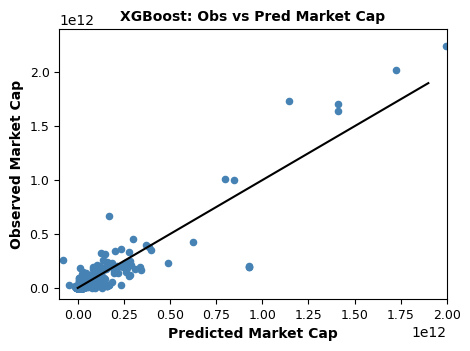

In [36]:
#obs vs pred scatterplot
axes031 = df_xgb_model_pred031.plot(x='mc_pred',y='mc_obs',kind='scatter',color='steelblue',figsize=(5,3.5))

axes031.set_title('XGBoost: Obs vs Pred Market Cap', fontsize = 10.0, fontweight='bold')
axes031.set_xlabel('Predicted Market Cap', fontsize = 10.0, fontweight='bold')
axes031.tick_params(axis='x', labelsize=9)
axes031.set_ylabel('Observed Market Cap', fontsize = 10.0, fontweight='bold') 
axes031.tick_params(axis='y', labelsize=9)
axes031.set_xlim(-1.0*10**11,2.0*10**12)     
axes031.set_ylim(-1.0*10**11,2.4*10**12)    

#y=x line
plt.plot([0,1.9*10**12],[0,1.9*10**12],'-',color='k')

plt.show()

I calculated feature importance using xgboost with parameter 'total_gain', which measures the cumulative improvement in fit attributable to a feature over all nodes in the tree.

In [37]:
#feature importance
df_xgb_model_featimp031 = pd.concat([pd.Series(df_x_train011.columns),pd.Series(xgb_model_best031.feature_importances_)],
    axis=1)
df_xgb_model_featimp031.columns = ['feature','importance']
df_xgb_model_featimp031.sort_values(by='importance',ascending=False,inplace=True)
df_xgb_model_featimp031.reset_index(inplace=True)
df_xgb_model_featimp031.columns = ['idx_feat','feat_label','importance']
df_xgb_model_featimp031

,idx_feat,feat_label,importance
0,7,ni,0.549719
1,15,cf_op,0.161078
2,4,gp,0.066386
3,12,sh_rprch,0.063209
4,1,rev,0.056283
5,13,div,0.033448
6,16,cf_op_ydy,0.017821
7,2,rev_yoy,0.010817
8,8,ni_ydy,0.009777
9,14,div_ydy,0.008135


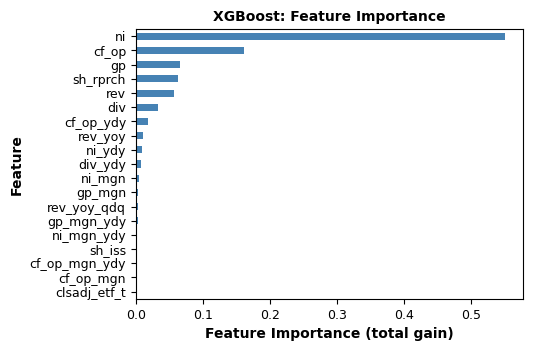

In [38]:
#feature importance plot
axes032 = df_xgb_model_featimp031.sort_values(by='importance').plot.barh(x='feat_label',y='importance',rot=0,color='steelblue',figsize=(5,3.5))

axes032.set_title('XGBoost: Feature Importance', fontsize = 10, fontweight='bold')
axes032.set_xlabel('Feature Importance (total gain)', fontsize = 10, fontweight='bold')
axes032.tick_params(axis='x', labelsize=9)
axes032.set_ylabel('Feature', fontsize = 10, fontweight='bold') 
axes032.tick_params(axis='y', labelsize=9)
axes032.get_legend().remove()

plt.show()

<b>3.3 XGBOOST DECISION TREE: CONCLUSIONS</b>

This analysis suggests the following conclusions for the xgboost decision tree model:

* Several of the best models fit similarly well in cross validation.  A large number of trees, approximately 1,000, were required to train the model with 4 splits in each iterative tree (max_depth = 4) and a slower learning rate of 0.1.  Trees with some randomness in feature selection in each boosting iteration (colsample_bynode = 0.8) performed better than models without this randomness.
* Similarly to the linear regression mode, the peformance of the model on the test data varies based on the metric.  Relative to the linear regression model, the r-squared metric improved somewhat, but the absolute prediction error using the median improved only slightly.
* The most important features in this tree model are net income, operating cash flow, share repurchase amount, gross profit, revenue and dividend amount.  Results for feature importance are similar to the linear model, but the set and rank of the top features does differ between the two models.  In particular, net income ranks much higher in the tree model relative to the linear regression model.

## 4 Support Vector Regression (SVR) Model

<b>4.1 SUPPORT VECTOR REGRESSION: MODEL SELECTION BY CROSS VALIDATION</b>

In this section, I fit a support vector regression model.  I evaluate a set of models by cross validation with a grid search of several hyperparameters using mean absolute error (MAE) as the scoring metric.

<b>SCALING THE DATA</b>

Support vector machine models, like some other statistical methods such as Principal Component Analysis, are very sensitive to scaling of the data and the data set I am analyzing here has values on very different scales.  As described above, I used the RobustScaler for the linear regression and xgboost decision tree models.  However, support vector machines perform better with data standardized to normal distributions with mean 0 and standard deviation of 1.  

In fact, I had difficulty fitting the support vector models and tuning the hyperparameters on the data transformed using RobustScaler to obtain a clear best-fitting model.  Thus, I used the nonlinear transformer, QuantileTransformer, to transform the data to normal distributions.  After this transformation, I was able to more easily fit the models and tune the hyperparameters to obtain best-fit models.

In [39]:
#scalers for {y,x}, y, x on training data
scaler_yx_041 = QuantileTransformer(output_distribution='normal')
scaler_y_041 = QuantileTransformer(output_distribution='normal')
scaler_x_041 = QuantileTransformer(output_distribution='normal')
sclprm_yx_train_041 = scaler_yx_041.fit(df_yx_train_core011)
sclprm_y_train_041 = scaler_y_041.fit(df_yx_train_core011.loc[:,['mktcap_sec_tp1']])
sclprm_x_train_041 = scaler_x_041.fit(df_yx_train_core011.loc[:,lst_yx_corefeat011])

#scale {y,x} data by training scale
yxscaled_train_041 = sclprm_yx_train_041.transform(df_yx_train_core011)
yxscaled_test_041 = sclprm_yx_train_041.transform(df_yx_test_core011)

#dataframe
df_yx_train_scld041 = pd.DataFrame(yxscaled_train_041, index=df_yx_train_core011.index, columns=lst_yx_coretrgtfeat011)
df_yx_test_scld041 = pd.DataFrame(yxscaled_test_041, index=df_yx_test_core011.index, columns=lst_yx_coretrgtfeat011)

#combine attribute, target, feature data with target and features scaled
df_yx_train_reg041 = pd.concat( [df_sec_yxdata_core011.loc[is_train_core_seq011,lst_yx_coreatt011], df_yx_train_scld041 ], axis=1 )
df_yx_test_reg041 = pd.concat( [df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011], df_yx_test_scld041 ], axis=1 )

In [40]:
#train, test data
df_x_train041 = df_yx_train_reg041.loc[:,lst_yx_corefeat011]
df_y_train041 = df_yx_train_reg041.loc[:,['mktcap_sec_tp1']]
df_x_test041 = df_yx_test_reg041.loc[:,lst_yx_corefeat011]
df_y_test041 = df_yx_test_reg041.loc[:,['mktcap_sec_tp1']]

Below are histograms of the target and features variables after scaling with QuantileTransformer.

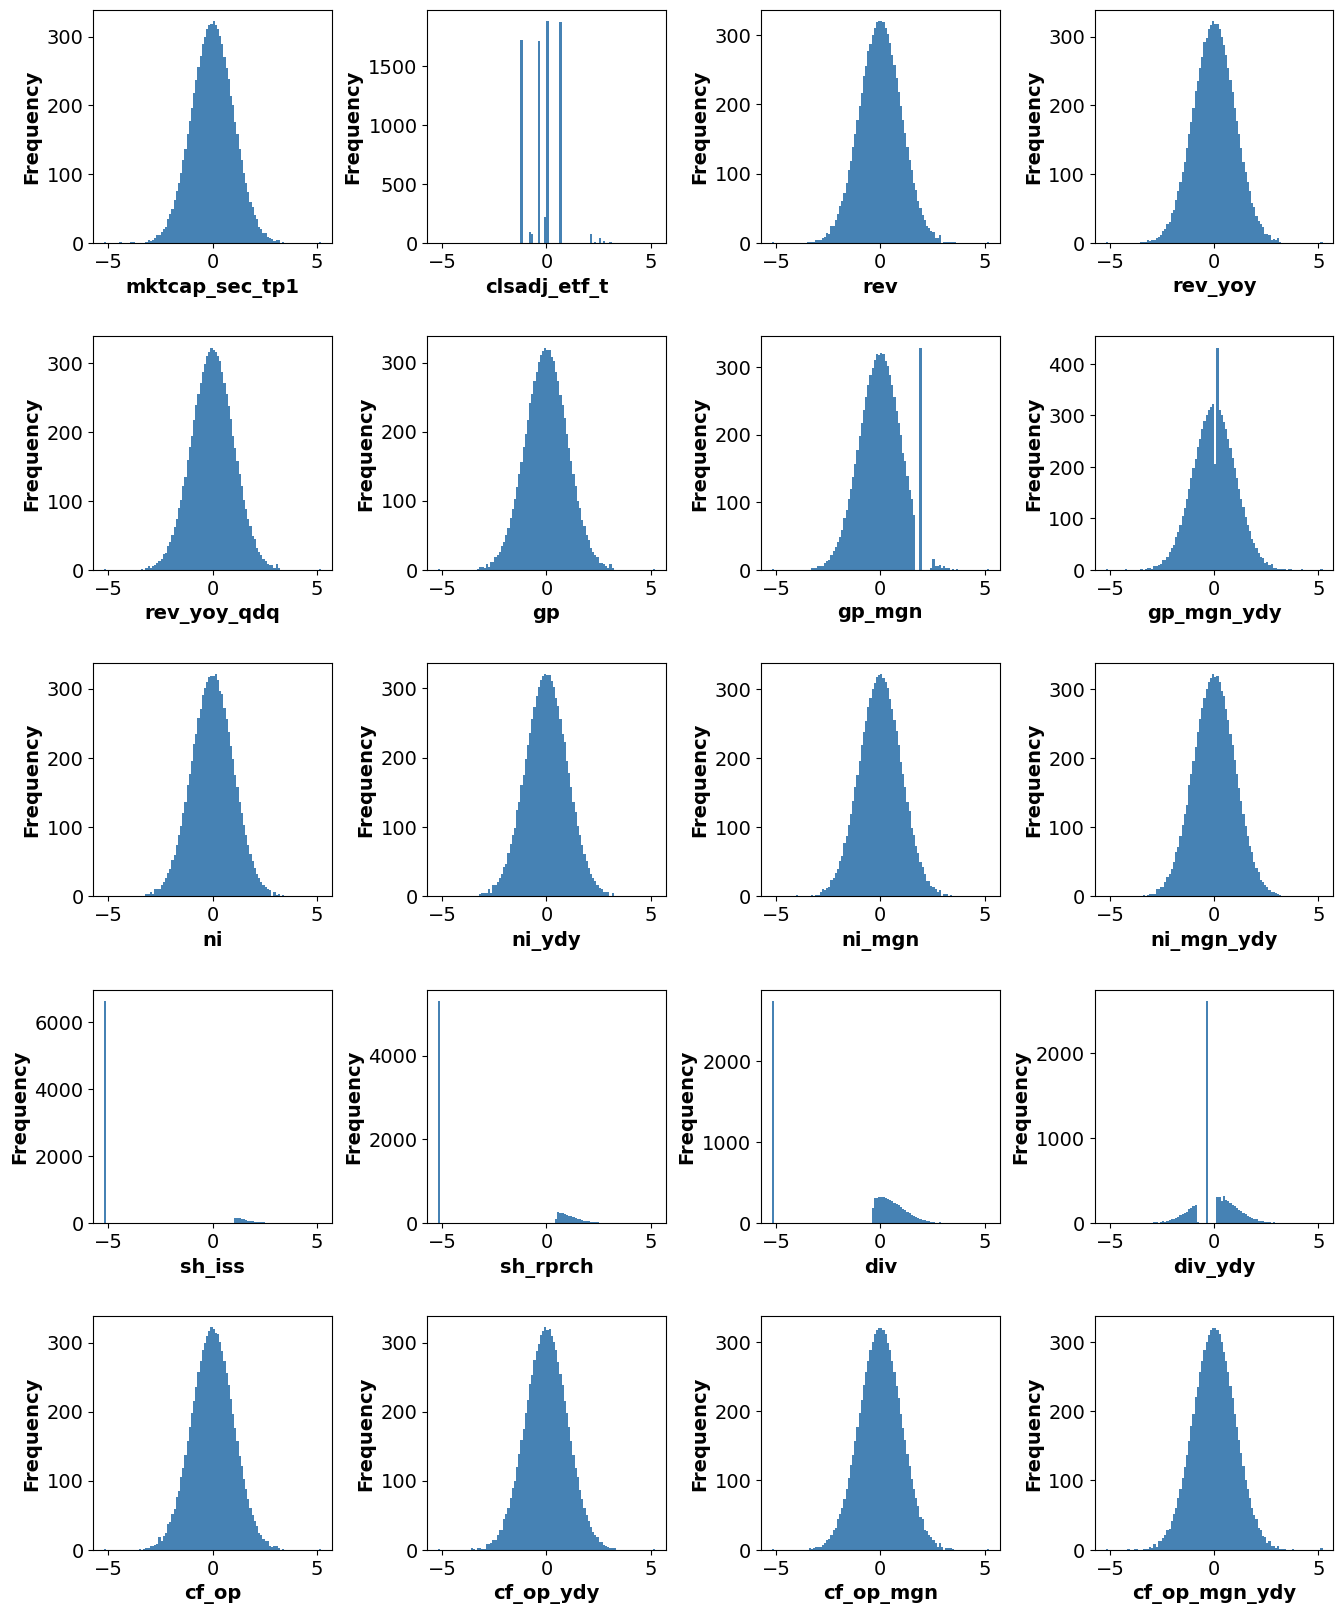

In [41]:
#plot histograms
fig041, axes041 = plt.subplots(nrows=5,ncols=4,figsize=(16,20))
fig041.subplots_adjust(wspace=0.4,hspace=0.4)
axes_flt041 = axes041.flatten()

n_coremet041 = len(lst_yx_coretrgtfeat011)

for idx041 in range(0,n_coremet041):
    colplt041 = lst_yx_coretrgtfeat011[idx041]

    
    df_yx_train_reg041.loc[:,colplt041].plot(ax=axes_flt041[idx041],kind='hist',bins=100,color='steelblue')
    axes_flt041[idx041].set_xlabel(colplt041, fontsize=14.0, fontweight='bold')
    axes_flt041[idx041].tick_params(axis='x', labelsize=14)
    axes_flt041[idx041].set_ylabel('Frequency', fontsize=14.0, fontweight='bold') 
    axes_flt041[idx041].tick_params(axis='y', labelsize=14) 

plt.show()

Here, I perform cross validation with a grid search over hyperparameters C, gamma, and epsilon.  Models are fit using the radial basis function as the kernel and mean absolute error (MAE) as the scoring metric.

In [42]:
### gridsearch cross validation
#clock start
gscv_start041 = dttm.datetime.now()
print(gscv_start041)

svr_model041 = SVR(kernel='rbf')
  
svr_gscv_grid041 = {'kernel':['rbf'],
    'C':[291,292,293],'gamma':[0.0009,0.0010,0.0011],'epsilon':[0.11,0.12,0.13]}      

svr_gscv041 = GridSearchCV( estimator = svr_model041, param_grid = svr_gscv_grid041,
    scoring='neg_mean_absolute_error', cv=4, verbose=2, n_jobs=4 )
svr_gscv041.fit(df_x_train041,df_y_train041.values.ravel())

#clock end
gscv_end041 = dttm.datetime.now()
gscv_elapsed041 = gscv_end041 - gscv_start041
print(gscv_start041,gscv_end041,gscv_elapsed041)

2021-10-29 14:20:54.800042
Fitting 4 folds for each of 27 candidates, totalling 108 fits
2021-10-29 14:20:54.800042 2021-10-29 14:36:32.294734 0:15:37.494692


Below are the results of the model selection for the top 10 models sorted by MAE (mean_test_score).  

In [43]:
pd.set_option('display.max_colwidth',80)
df_svr_gscv_res041 = pd.DataFrame(svr_gscv041.cv_results_)
df_svr_gscv_res041.sort_values(by='rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
13,28.080287,1.854523,5.847955,0.472983,292,0.12,0.001,rbf,"{'C': 292, 'epsilon': 0.12, 'gamma': 0.001, 'kernel': 'rbf'}",-0.576668,-0.414425,-0.407603,-0.838318,-0.559254,0.174752,1
22,25.371414,1.548870,5.461628,0.137387,293,0.12,0.001,rbf,"{'C': 293, 'epsilon': 0.12, 'gamma': 0.001, 'kernel': 'rbf'}",-0.576779,-0.414378,-0.407611,-0.838312,-0.559270,0.174761,2
4,25.770205,1.755527,5.588467,0.208210,291,0.12,0.001,rbf,"{'C': 291, 'epsilon': 0.12, 'gamma': 0.001, 'kernel': 'rbf'}",-0.576831,-0.414448,-0.407609,-0.838436,-0.559331,0.174798,3
10,30.513950,4.291257,7.259456,0.148966,292,0.11,0.001,rbf,"{'C': 292, 'epsilon': 0.11, 'gamma': 0.001, 'kernel': 'rbf'}",-0.578840,-0.413592,-0.408334,-0.838163,-0.559732,0.174762,4
1,26.391711,1.277990,5.829822,0.071433,291,0.11,0.001,rbf,"{'C': 291, 'epsilon': 0.11, 'gamma': 0.001, 'kernel': 'rbf'}",-0.578867,-0.413611,-0.408316,-0.838232,-0.559756,0.174790,5
3,23.929316,1.399779,5.549731,0.151225,291,0.12,0.0009,rbf,"{'C': 291, 'epsilon': 0.12, 'gamma': 0.0009, 'kernel': 'rbf'}",-0.576742,-0.414983,-0.407629,-0.839812,-0.559791,0.175230,6
19,26.056034,1.495774,5.575236,0.122938,293,0.11,0.001,rbf,"{'C': 293, 'epsilon': 0.11, 'gamma': 0.001, 'kernel': 'rbf'}",-0.579095,-0.413657,-0.408359,-0.838166,-0.559819,0.174751,7
21,23.765148,1.779227,5.566797,0.194471,293,0.12,0.0009,rbf,"{'C': 293, 'epsilon': 0.12, 'gamma': 0.0009, 'kernel': 'rbf'}",-0.576941,-0.414970,-0.407608,-0.839770,-0.559822,0.175225,8
12,27.781802,1.449763,6.733880,0.319571,292,0.12,0.0009,rbf,"{'C': 292, 'epsilon': 0.12, 'gamma': 0.0009, 'kernel': 'rbf'}",-0.576982,-0.414955,-0.407609,-0.839872,-0.559855,0.175270,9
25,26.011552,2.025963,5.701634,0.170841,293,0.13,0.001,rbf,"{'C': 293, 'epsilon': 0.13, 'gamma': 0.001, 'kernel': 'rbf'}",-0.578561,-0.414591,-0.407780,-0.838728,-0.559915,0.174892,10


<b>4.2 SUPPORT VECTOR REGRESSION: TESTING</b>

Based on the above cross validation results, I selected a model with the following hyperparameters for further analysis and testing,

kernel='rbf', C=292, gamma=0.001, epsilon=0.12

noting that many of the best models performed very similarly in cross validation.

I fit this model to the training data, generate predictions for the target variable using the test data, and evaluate the accuracy of the predictions.  Accuracy is assessed on the original, untransformed test data. I also measure the relative importance of the features in the model.

In [44]:
#support vector regression - best model

#RBF KERNEL
#{'kernel':['rbf'],'C':[291,292,293],'gamma':[0.0009,0.0010,0.0011],'epsilon':[0.11,0.12,0.13]} 
#C=292, gamma=0.0010, epsilon=0.12; MAE -0.559254
#{'kernel':['rbf'],'C':[270,290,300,310,330],'gamma':[0.0008,0.0010,0.0012],'epsilon':[0.08,0.10,0.12]}  
#C=290, gamma=0.0010, epsilon=0.12; MAE -0.559268
#{'kernel':['rbf'],'C':[200,250,300,350,400],'gamma':[0.0005,0.001,0.00015],'epsilon':[0.10]}  
#C=300, gamma=0.0010, epsilon=0.10; MAE -0.560722

svr_model_best041 = SVR(kernel='rbf', C=292, gamma=0.001, epsilon=0.12)    
svr_model_best041.fit(df_x_train041,df_y_train041.values.ravel())

SVR(C=292, epsilon=0.12, gamma=0.001)

Predictions for the target variable and associated accuracy metrics are calculated on the original, untransformed data.

In [45]:
#predictions

#scaled
df_svr_model_pred041 = pd.concat([df_y_test041,pd.Series(svr_model_best041.predict(df_x_test041),
    index=df_x_test041.index)],axis=1)
df_svr_model_pred041.columns = ['y_obs','y_pred']

#unscaled, back-transform
#observed
df_svr_model_pred041 = pd.concat([df_svr_model_pred041,df_yx_test_core011.loc[:,'mktcap_sec_tp1']],axis=1)
df_svr_model_pred041.rename(columns={'mktcap_sec_tp1':'mc_obs'},inplace=True)
#predicted
df_svr_model_pred_temp041 = df_svr_model_pred041.loc[:,['y_pred']].copy()
df_svr_model_pred_temp041.rename(columns={'y_pred':'mktcap_sec_tp1'},inplace=True)
ary_svr_y_pred_temp041 = sclprm_y_train_041.inverse_transform(df_svr_model_pred_temp041.loc[:,['mktcap_sec_tp1']])
df_svr_model_pred041 = pd.concat([df_svr_model_pred041,pd.DataFrame(ary_svr_y_pred_temp041,
    index=df_x_test041.index,columns=['mc_pred'])],axis=1)

#fit metrics
df_svr_model_pred041.loc[:,'mc_resid'] = df_svr_model_pred041.loc[:,'mc_obs'] - df_svr_model_pred041.loc[:,'mc_pred']
df_svr_model_pred041.loc[:,'mc_ae'] = df_svr_model_pred041.loc[:,'mc_resid'].abs()
df_svr_model_pred041.loc[:,'mc_ape'] = df_svr_model_pred041.loc[:,'mc_ae']/df_svr_model_pred041.loc[:,'mc_obs'].abs()
df_svr_model_pred041 = pd.concat([df_sec_yxdata_core011.loc[~is_train_core_seq011,lst_yx_coreatt011],
    df_svr_model_pred041],axis=1)

df_svr_model_pred041.head(10)

,ticker,mkt_cap_202109,fisc_seq,fisc_intvl,rpt_ccy,inscope_flg,fisc_date_t,fisc_date_tm1,fisc_date_tm4,fisc_date_tm5,meas_date_tp1,y_obs,y_pred,mc_obs,mc_pred,mc_resid,mc_ae,mc_ape
0,AAPL,2.358033e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,3.930606,3.022197,2.245600e+12,1.359968e+12,8.856313e+11,8.856313e+11,0.394385
5,MSFT,2.172555e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,3.407169,2.932539,2.020644e+12,1.139587e+12,8.810574e+11,8.810574e+11,0.436028
10,GOOGL,1.820299e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,3.153750,2.902467,1.644663e+12,1.051610e+12,5.930535e+11,5.930535e+11,0.360593
15,GOOG,1.820298e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,3.181377,2.902467,1.702156e+12,1.051610e+12,6.505461e+11,6.505461e+11,0.382189
20,AMZN,1.662777e+12,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,3.198703,2.091209,1.735721e+12,1.767889e+11,1.558932e+12,1.558932e+12,0.898147
25,FB,9.670962e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,2.889900,2.754511,1.012507e+12,7.321448e+11,2.803622e+11,2.803622e+11,0.276899
30,TSLA,7.765921e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,2.729834,1.068483,6.632374e+11,2.569369e+10,6.375437e+11,6.375437e+11,0.961260
35,BRK-B,6.240806e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,2.887510,2.117914,1.004905e+12,1.821371e+11,8.227675e+11,8.227675e+11,0.818752
40,NVDA,5.168906e+11,5.0,91.0,USD,True,2021-05-02,2021-01-31,2020-04-26,2020-01-26,2021-07-30,1.874640,1.464269,1.210672e+11,5.174607e+10,6.932109e+10,6.932109e+10,0.572584
45,V,5.057191e+11,5.0,91.0,USD,True,2021-03-31,2020-12-31,2020-03-31,2019-12-31,2021-06-28,2.667362,2.378325,4.558462e+11,2.420751e+11,2.137710e+11,2.137710e+11,0.468954


As above, for the model predictions of the target variable I calculate r-squared and absolute prediction error (APE) - both mean and median.  Interestingly, r-squared is lower in the SVR model, but absolute prediction error, while still quite high, is much improved.

In [46]:
#r-squared, mean-ape, median-ape
svr_r2 = r2_score(df_svr_model_pred041.loc[:,'mc_obs'], df_svr_model_pred041.loc[:,'mc_pred'])
svr_meanape = df_svr_model_pred041.loc[:,'mc_ape'].mean()
svr_medape = df_svr_model_pred041.loc[:,'mc_ape'].median()

df_model_testmet_smy011 = df_model_testmet_smy011.append(pd.Series(['SVR',svr_r2,svr_meanape,svr_medape],
    index=df_model_testmet_smy011.columns),ignore_index=True)
df_model_testmet_smy011

,model,r-squared,mean-ape,median-ape
0,LR,0.700325,2.347315,0.597431
1,XGB,0.835160,2.101847,0.593798
2,SVR,0.642342,1.294715,0.408159


Observed market capitalization is plotted against its prediction on the test data.  Values have been transformed back to their original scale.

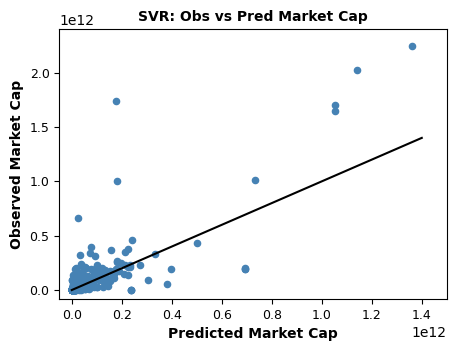

In [47]:
#obs vs pred scatterplot
axes041 = df_svr_model_pred041.plot(x='mc_pred',y='mc_obs',kind='scatter',color='steelblue',figsize=(5,3.5))

axes041.set_title('SVR: Obs vs Pred Market Cap', fontsize = 10.0, fontweight='bold')
axes041.set_xlabel('Predicted Market Cap', fontsize = 10.0, fontweight='bold')
axes041.tick_params(axis='x', labelsize=9)
axes041.set_ylabel('Observed Market Cap', fontsize = 10.0, fontweight='bold') 
axes041.tick_params(axis='y', labelsize=9)
axes041.set_xlim(-0.5*10**11,1.5*10**12)     
axes041.set_ylim(-0.8*10**11,2.4*10**12)     

#y=x line
plt.plot([0,1.4*10**12],[0,1.4*10**12],'-',color='k')

plt.show()

Feature importance is calculated using a sensitivity analysis of the best-fit model and the associated support vectors.  Specifically, the partial derivative of the target with respect to each feature is calculated numerically.<br>  
Using the support vectors from the training data and the associated support vectors, each feature is perturbed by 1% in the set of support vectors and the resulting change in the target under the SVR model is calculated.  The change in the target is averaged over support vectors for each feature and used as a measure of feature importance.  Relative importance values are calculated by dividing each importance value by the sum of the absolute values of the importance values.  Relative importance values are then sorted by descending magnitude.

In [48]:
#feature importance - perturbations

#features
n_corefeat041 = len(lst_yx_corefeat011)
#support vectors
df_x_sv_best041 = pd.DataFrame(svr_model_best041.support_vectors_,index=list(svr_model_best041.support_),
        columns=df_x_train041.columns)
#y for support vectors
df_y_sv_best041 = pd.DataFrame(svr_model_best041.predict(df_x_sv_best041),
    index=df_x_sv_best041.index,columns=['y_pred'])

for ct041 in range(0,n_corefeat041):
    
    #feature label
    coln041 = lst_yx_corefeat011[ct041]
    
    #perturbation by %
    df_x_sv_best_pbit041 = df_x_sv_best041.copy()
    df_x_sv_best_pbit041.iloc[:,ct041] = df_x_sv_best_pbit041.iloc[:,ct041]*1.01
    
    #calc y (x+bit), y delta
    df_y_sv_best_pbit041 = pd.DataFrame(svr_model_best041.predict(df_x_sv_best_pbit041),
        index=df_x_sv_best_pbit041.index,columns=['y_pred'])
    df_y_sv_best_deltinsrt041 = pd.DataFrame(columns=[coln041])
    df_y_sv_best_deltinsrt041 = df_y_sv_best_pbit041.loc[:,'y_pred'] - df_y_sv_best041.loc[:,'y_pred']
    
    #save
    if ct041 == 0:
        df_y_sv_best_delt041 = df_y_sv_best_deltinsrt041
    else:
        df_y_sv_best_delt041 = pd.concat([df_y_sv_best_delt041,df_y_sv_best_deltinsrt041],ignore_index=True,axis=1)
        

In [49]:
#feature importance
df_svr_featimp041 = pd.DataFrame(columns=['feat_label','y_delta_avg','y_deltaabs_avg'])
df_svr_featimp041.loc[:,'feat_label'] = pd.Series(lst_yx_corefeat011)
#mean delta
df_svr_featimp041.loc[:,'y_delta_avg'] = df_y_sv_best_delt041.mean()
#mean delta abs
df_svr_featimp041.loc[:,'y_deltaabs_avg'] = df_y_sv_best_delt041.abs().mean()
#mean delta, relative
df_svr_featimp041.loc[:,'y_delta_relavg'] = df_svr_featimp041.loc[:,'y_delta_avg']/df_svr_featimp041.loc[:,'y_deltaabs_avg'].sum()
#mean delta abs, relative
df_svr_featimp041.loc[:,'y_deltaabs_relavg'] = df_svr_featimp041.loc[:,'y_deltaabs_avg']/df_svr_featimp041.loc[:,'y_deltaabs_avg'].sum()

#idx_feat	feat_label	importance
df_svr_featimp041.sort_values(by='y_deltaabs_relavg',ascending=False,inplace=True)

df_svr_featimp041.head(19)

,feat_label,y_delta_avg,y_deltaabs_avg,y_delta_relavg,y_deltaabs_relavg
11,sh_iss,0.013160,0.013160,0.285224,0.285224
13,div,0.010720,0.010900,0.232342,0.236237
12,sh_rprch,0.008184,0.008184,0.177370,0.177370
1,rev,-0.000720,0.002108,-0.015603,0.045689
2,rev_yoy,0.000488,0.001216,0.010582,0.026354
8,ni_ydy,0.000642,0.001215,0.013905,0.026326
5,gp_mgn,-0.000558,0.001003,-0.012104,0.021732
4,gp,0.000074,0.000990,0.001599,0.021447
7,ni,0.000430,0.000985,0.009312,0.021356
15,cf_op,0.000477,0.000895,0.010337,0.019406


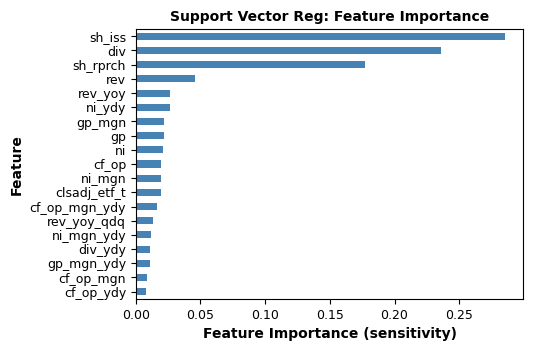

In [50]:
#feature importance plot
axes042 = df_svr_featimp041.sort_values(by='y_deltaabs_relavg').plot.barh(x='feat_label',y='y_deltaabs_relavg',
    rot=0,color='steelblue',figsize=(5,3.5))

axes042.set_title('Support Vector Reg: Feature Importance', fontsize = 10, fontweight='bold')
axes042.set_xlabel('Feature Importance (sensitivity)', fontsize = 10, fontweight='bold')
axes042.tick_params(axis='x', labelsize=9)
axes042.set_ylabel('Feature', fontsize = 10, fontweight='bold') 
axes042.tick_params(axis='y', labelsize=9)
axes042.get_legend().remove()

plt.show()

<b>4.3 SUPPORT VECTOR REGRESSION: CONCLUSIONS</b>

This analysis suggests the following conclusions for the support vector regression model:

* Using data transformed to normal distributions with 0 mean and unit variance to faciliate model fitting, several of the best models fit similarly well in cross validation with tuning of hyperparameters.
* In terms of accuracy in predicting the test data, relative to the linear regression and xgboost tree models, r-squared declined, but absolute prediction error, while still high, improved.
* Interestingly, the most important features for the SVR model differ quite a bit from the other two models.  Shares issued (in USD), dividend amount, and shares repurchased (in USD) dominate in importance, but, after these top 3 features, there is a long tail of features with moderate importance.  One explanation is that the different scaling methods, RobustScaler (used for linear regression and xgboost tree models) versus QuantileScaler (used for support vector regression), are contributing to the differences in feature importance across models.  These three features, shares issued, dividend amount, and shares repurchased, have unusual distributions because of the high frequency of zero values, which may certainly be influencing how these features are modeled.
* Finally, comparing the average feature importance (y_delta_avg) to its average absolute value (y_deltaabs_avg) indicates nonlinear effects of the feature when these values are different.  The top ranking features have largely linear effects, whereas many of the other features appear to have nonlinear effects.

## 4 Conclusions

The key results of this notebook are:
<ol type="1">
  <li>I fit three different types of models to a training data set: a linear regression model, an xgboost decision tree model and a support vector regression model.  A best-fit parameterization of each model was identified by cross validation with a grid search over the parameter space and the fit was assessed by mean absolute error (MAE).</li>
  <li>The best-fit model for each model type was evaluated on a test data set using r-squared, and absolute prediction error (APE), both mean and median. All models have a relatively high r-squared (about 64% to 85%), but also quite high mean-APE and median-APE.  Mean-APE was above 100% and as high as 230% and median-APE ranged from about 40% to 58%.  The xgboost decision tree has the highest r-squared whereas the support vector regression model has the lowest median-APE.
  <li>The different models also suggest different rankings of the features in terms of their importance in predicting market capitalization.  The linear regression and xgboost decision tree are similar in terms of the top features, with some notable differences, such as net income.  However, the feature importance results for the support vector regression model differs from the other two models in that it has about 3 very important features but also a long tail of moedrately important features.  In contrast, the other two models have about 6 very important features with the remaining features being much less important.</li>
  <li>long tails, segment data, transform/scaling</li>
  <li>abc</li>
</ol> 